# Analysis of ECoG decoding via sliding window

This notebook describes the ECoG sliding-window decoding results reported in the manuscript "Evidence for a deep, distributed, and dynamic semantic code in human anterior temporal cortex" archived at: https://www.biorxiv.org/content/10.1101/695049v1.abstract

## Required libraries

In [1]:
library(lsa) #provides cosine distance functions
library(fields) #provides image.plot function
library(segmented) #For piecewise linear regression
library(BurStMisc) #For computing ntiles
library(viridis) #For plotting colors

Loading required package: SnowballC
Warning message:
"package 'fields' was built under R version 3.6.3"Loading required package: spam
Warning message:
"package 'spam' was built under R version 3.6.3"Loading required package: dotCall64
Loading required package: grid
Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: 'spam'

The following objects are masked from 'package:base':

    backsolve, forwardsolve

Loading required package: maps
See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 
Warning message:
"package 'segmented' was built under R version 3.6.3"Warning message:
"package 'BurStMisc' was built under R version 3.6.3"

## Load custom functions

These functions are used to generate the plots in the paper.

In [75]:
get.clust <- dget("get_clust.r") #Clusters data
plot.clacc <- dget("plot_clacc.r")  #Plots mean accuracy for each cluster of models
plot.cbars <- dget("plot_cbars.r")  #Plot amount of time each cluster of models performs above chance
plot.clust.compare <- dget("plot_cluster_compare.r") #Contrast fit of clusters
plot.coef.var <- dget("plot_coef_var.r") #Compute and plot var of coefficient change
plot.window.widen <- dget("plot_window_widen.r") #Compute width of generalization window for each decoder


## Read decoding data

Decoding data for each participant is stored in the subdirectory SubjectData. Each is a csv file in which rows correspond to a decoding model trained on a given time window and columns correspond to the time-window in which the model was tested. The data for each participant are loaded as elements in a list. We then compute the mean accuracy for each matrix element across the 8 participants.

In [8]:
f <- list.files(path = "./Data/SjDecodeAcc/") #Get filenames
f <- paste("./Data/SjDecodeAcc/", f, sep="")  #Append path
nsjs <- length(f) #number of subjects

acclist <- list() #Initialize list to contain each participant's data

#Loop to read data
for(i1 in c(1:nsjs)){
    acclist[[i1]] <- as.matrix(read.csv(f[i1], header = F))
    }

#acclist now contains data for each participant

accmean <- acclist[[1]] #initialize this with first subject's of data
for(i1 in c(2:nsjs)) accmean <- accmean + acclist[[i1]] #Add each subject's data
accmean <- accmean/nsjs #Divide by number of participants



In [13]:
f <- list.files(path = "./Data/SjDecodeAcc/") #Get filenames
f <- paste("./Data/SjDecodeAcc/", f, sep="")  #Append path
nsjs <- length(f) #number of subjects

acc.all <- array(0, dim = c(163,164,nsjs)) #Initialize data array

#Read sj data into array
for(i in c(1:nsjs)) acc.all[,,i] <- as.matrix(read.csv(f[i], header = F))

#Compute mean accuracy across subjects
accmean <- apply(acc.all, c(1,2), mean)


## Generate plots

First we look at the average prediction accuracy for each of the 163 models across all time-windows, as an image heat-plot (manuscript Figure 4B). We use the image.plot function from the fields package. The matrix indexing generates the image plot so that time increases right-to-left and top-to-bottom in the plot.

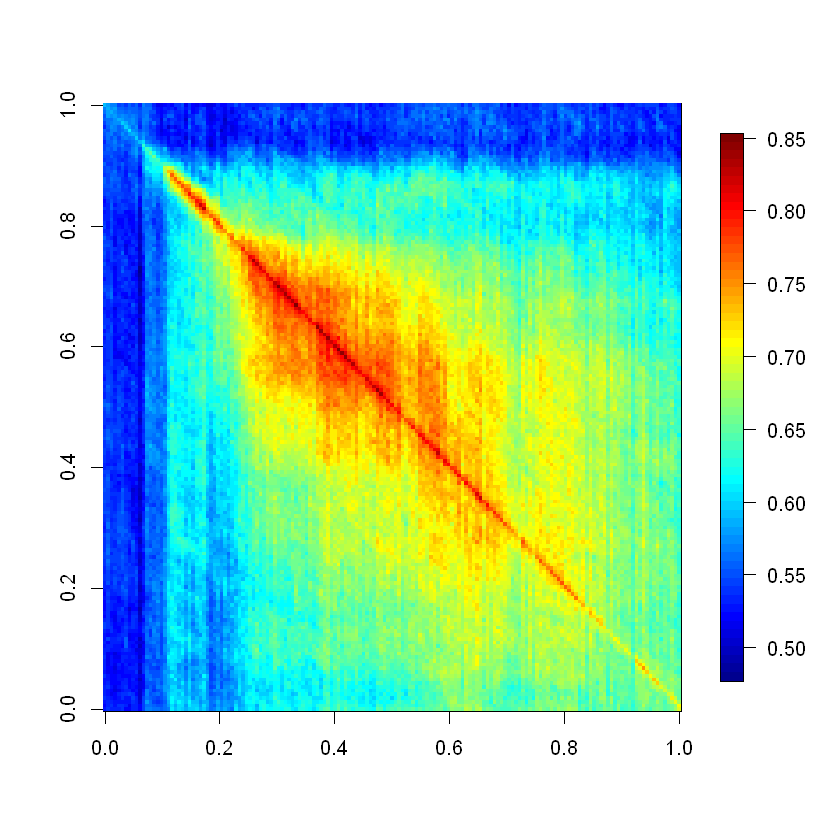

In [18]:
image.plot(accmean[,164:1])

Next we cluster the rows of the matrix (the different decoding models) on the basis of the similarities of their decoding profiles over time and plot the mean decoding accuracy over time for each cluster (see paper; Figure 4C). The plot_clacc.r function is documented in the code comments. Default parameters are those reported in the paper.

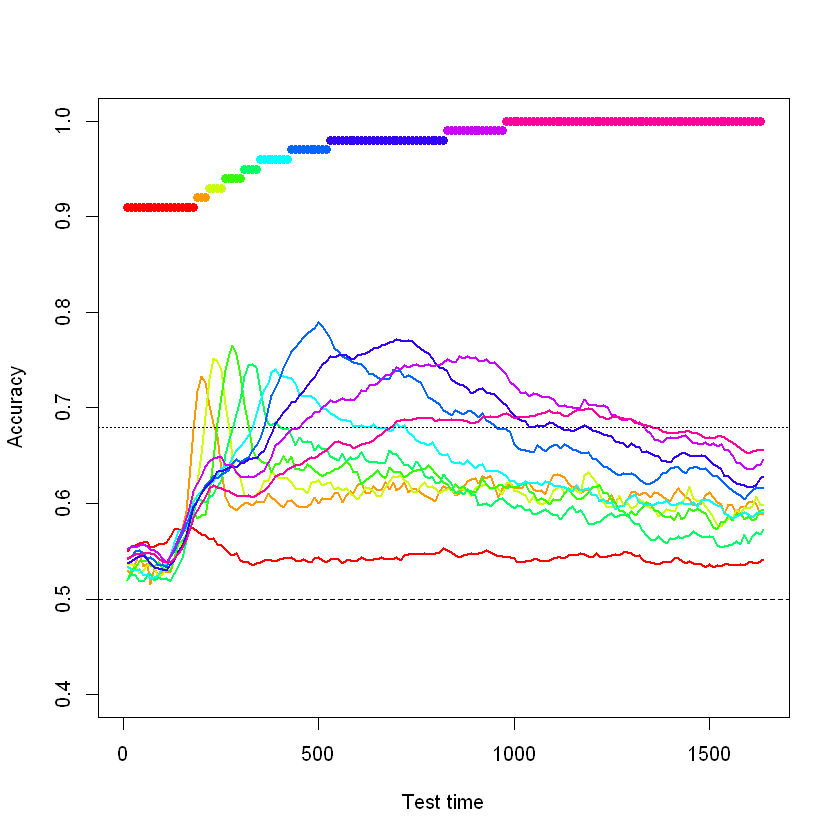

In [19]:
plot.clacc(accmean)

Finally we plot the amount of time each cluster of classifiers shows above-threshold classification accuracy, where the threshold is determined by Bonferonni-corrected signifiance threshold on the binomial distribution. Again the script paramters are explained in the code comments; defaults correspond to those used in the paper.

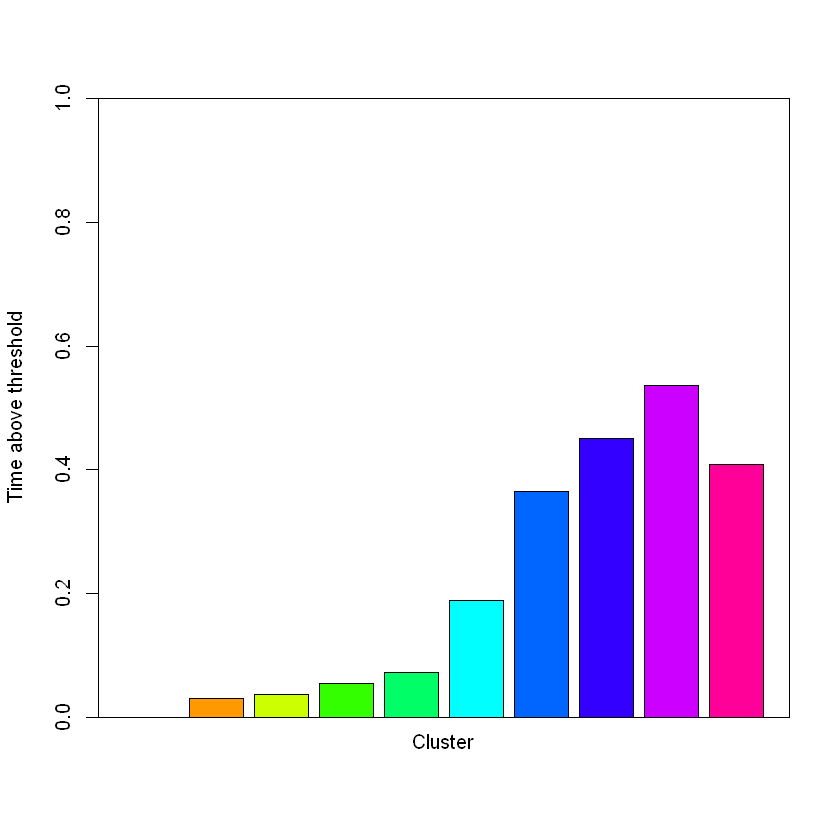

In [20]:
plot.cbars(accmean)

## Statistical test of overlapping-waves pattern

To determine whether the mean decoding accuracy of the various clusters differ reliably at different points in time, we computed mean cluster accuracy for each cluster of timepoints separately for each subject, then contrasted the best-performing cluster at each point with each other cluster. For each contrast we compute the probability that the decoding accuracy differs reliably across subjects, and correct these probabilities to control the false discovery rate at 0.05. We plot the results as a heatmap shown as Figure 5A in the paper

In [89]:
tclust <- get.clust(accmean, 10, dmeth = "cos") #Cluster timepoints as in line [19] above

#Initialize array to contain mean accuracy of each cluster at each timepoint in each subject
clustacc.by.sj <- array(0, dim = c(10,164,8)) 

#Compute mean accuracy for each cluster of timepoints in each subject
for (i in c(1:10)) clustacc.by.sj[i,,] <- apply(acc.all[tclust==i,,], c(2,3), mean)


The _plot.cluster.compare_ function computes a one-tailed t.test comparing the best-performing cluster to all others at each timepoint, then corrects these to control the false discovery rate, bins the resulting probabilities by significance band, and plots the result as a heat plot.

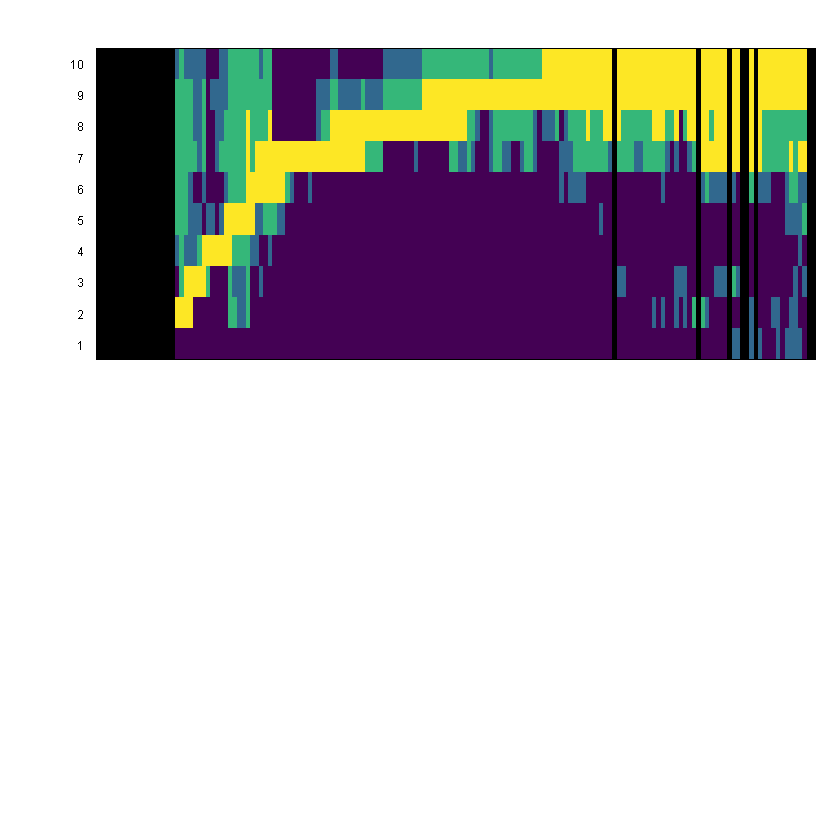

In [90]:
plot.clust.compare <- dget("plot_cluster_compare.r") #Contrast fit of clusters
par(mar = c(20,4,2,1))
tmp <- plot.clust.compare(tmp = clustacc.by.sj, thresh = 0.005, aa = acc.all)

In the above, each cluster of decoders is one horizontal band, and time runs along the horizontal axis. Black indicates timepoints where decoding was not reliably above chance across subjects. Yellow shows the best-performing cluster of decoders and other clusters that are not reliably different from the best. Increasingly darker colors show clusters that are increasingly reliably different from the best performing cluster as corrected p < 0.05, p < 0.01 and p < 0.005

### Width of generalization window plotted against fit time

Figure 5b shows how the width of the generalization window for each classifier varies as a function of when the window was fit. The following code reconstructs this from the decoder hold-out accuracy data contained in _acc.all_.

First we compute the (uncorrected) probability that the mean hold-out accuracy of the decoder across subjects differs from chance. Successful generalization of a decoder is defined with respect to this probability.

In [104]:
pval.meanacc <- matrix(0, dim(accmean)[1], dim(accmean)[2]) #Initialize matrix for p-values

#Compute probability of null at each train/test window
for(i in c(1:163)) for(j in c(1:164)) pval.meanacc[i,j] <- t.test(acc.all[i,j,] - 0.5)$p.value
    



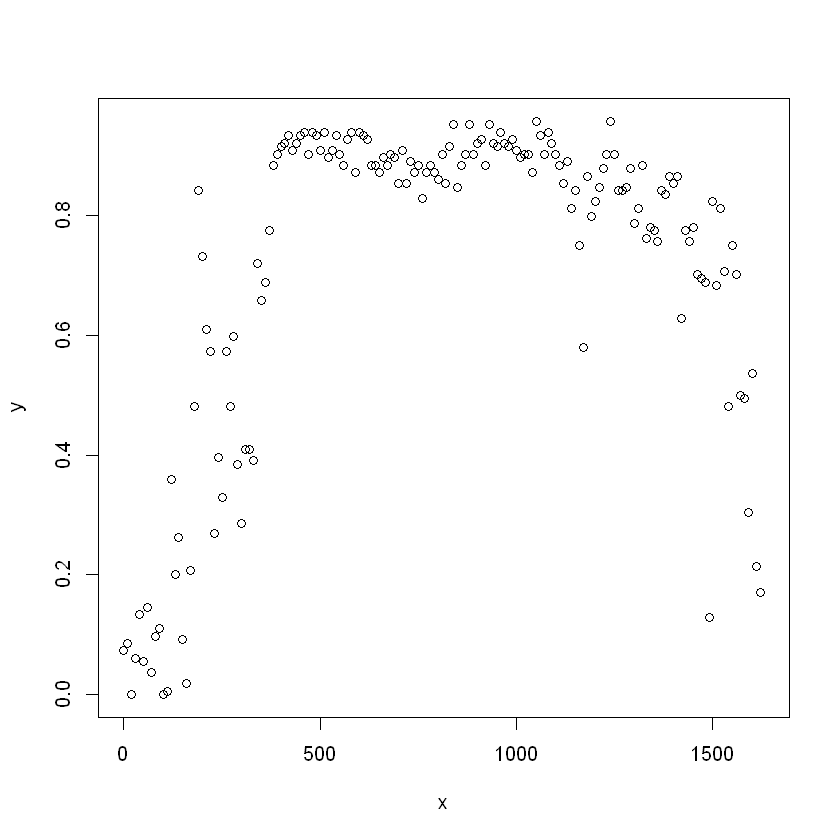

In [105]:
#Plot relation for all data
x <- c(0:163) * 10 #Starting time for each window
y <- rowSums(pval.meanacc < 0.01)[1:164]/164 #Proportion of time window probability is below threshold of p < 0.01
plot(x,y)

We want to fit this relationship with a piecewise linear regression using the _segmented_ library loaded earlier. This contains the function _selegmented_ that will fit models with an increasing number of break points, using the BIC to decide how many breakpoints are needed to balance fit improvement with number of free parameters.

Because observations from overlapping windows are not independent, however, we want to fit the model only to non-overlapping windows. Since each window is 50ms long and they shift by 10ms, this means we want every fifth timepoint.

In [106]:
xno <- x[c(0:31)*5 + 1] #Every fifth window beginning with the first for x
yno <- y[c(0:31)*5 + 1] #Every fifth window beginning with the first for y

selgmented(lm(yno~xno))

Hypothesis testing to detect no. of breakpoints
statistic: score   level: 0.05   Bonferroni correction: FALSE 
p-value '0 vs 2' = 1.562e-05   p-value '1 vs 2' = 0.6307 
Overall p-value = 0.0001235
No. of selected breakpoints:  1 


Call: segmented.lm(obj = olm, seg.Z = seg.Z, npsi = 1, control = control)

Meaningful coefficients of the linear terms:
(Intercept)          xno       U1.xno  
  -0.062639     0.002089    -0.002203  

Estimated Break-Point(s):
psi1.xno  
   473.7  

From BIC only one breakpoint is needed to fit the data. The _plot.window.widen_ function fits a piecewise linear model to the non-overlapping window data given the specified number of breakpoints, then plots the result as shown in Figure 5B.

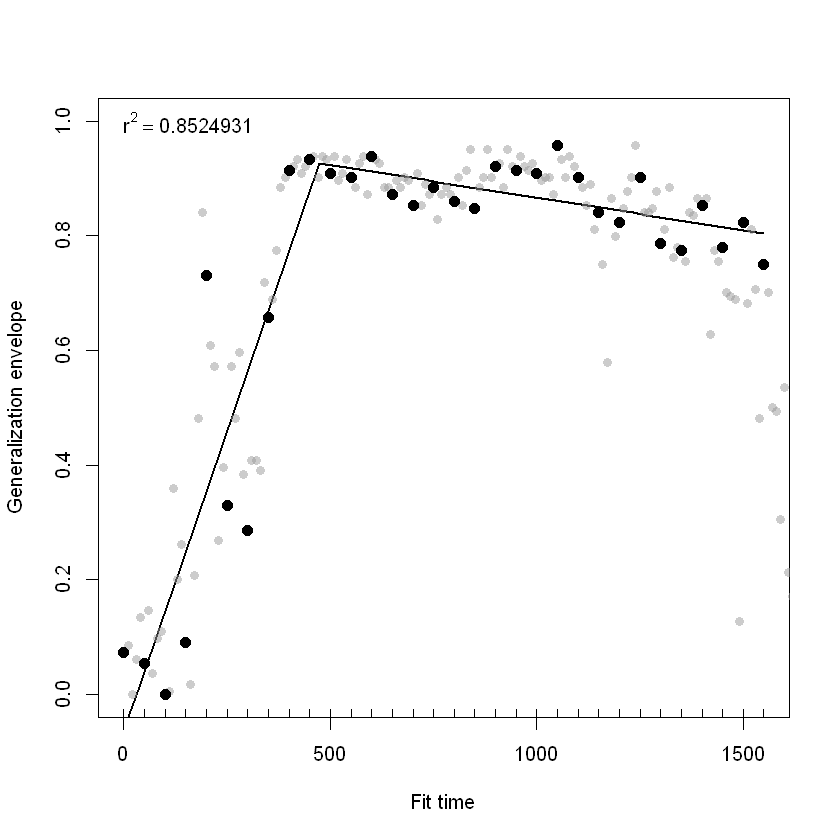

In [108]:
plot.window.widen(tmp = pval.meanacc, thresh = 0.01, nbp = 1, rflag = T)


The first segment shows a linear increase in generalization time up to the breakpoint of 473 ms. We can compute the fit for just this segment of the model by computing it for the first 10 non-overlapping time points which span from 0 - 450 ms.

In [52]:
summary(lm(yno[1:10] ~ xno[1:10]))


Call:
lm(formula = yno[1:10] ~ xno[1:10])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.27738 -0.14224  0.00161  0.11577  0.37661 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept) -0.0626386  0.1183541  -0.529  0.61100   
xno[1:10]    0.0020887  0.0004434   4.711  0.00152 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2014 on 8 degrees of freedom
Multiple R-squared:  0.735,	Adjusted R-squared:  0.7019 
F-statistic: 22.19 on 1 and 8 DF,  p-value: 0.00152


### Variance of coefficient change

Figure 5c shows the _variance of coefficient change_ plotted against the mni-Y coordinate (anterior/posterior) for all electrodes divded into deciles based on anterior/posterior location. The function _plot.coef.var_ computes this statistic for each electrode based on the mean decoder coefficient in each time window, then averages it over a specified number of _ntiles_ and plots the result. Comments in the function code further document this functionality.

In [42]:
#Read in data indicating the mean decoder coefficient for each electrode at every time window
mncoeff <- as.matrix(read.csv("Data/electrode_mean_coefficients.csv", header = F))

#Read in data indicating the subject number and MNI coordinates for each electrode, in same order as mncoeff
mni  <- read.csv("Data/electrode_mni_coords.csv", header = T)

head(mni)

sj,X,Y,Z
1,-24,0,-46
1,-32,2,-50
1,-42,4,-50
1,-50,6,-46
1,-54,10,-38
1,-24,-8,-42


Warning message in ntile(coor, ntl, result = "numeric"):
"common values across groups: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10"

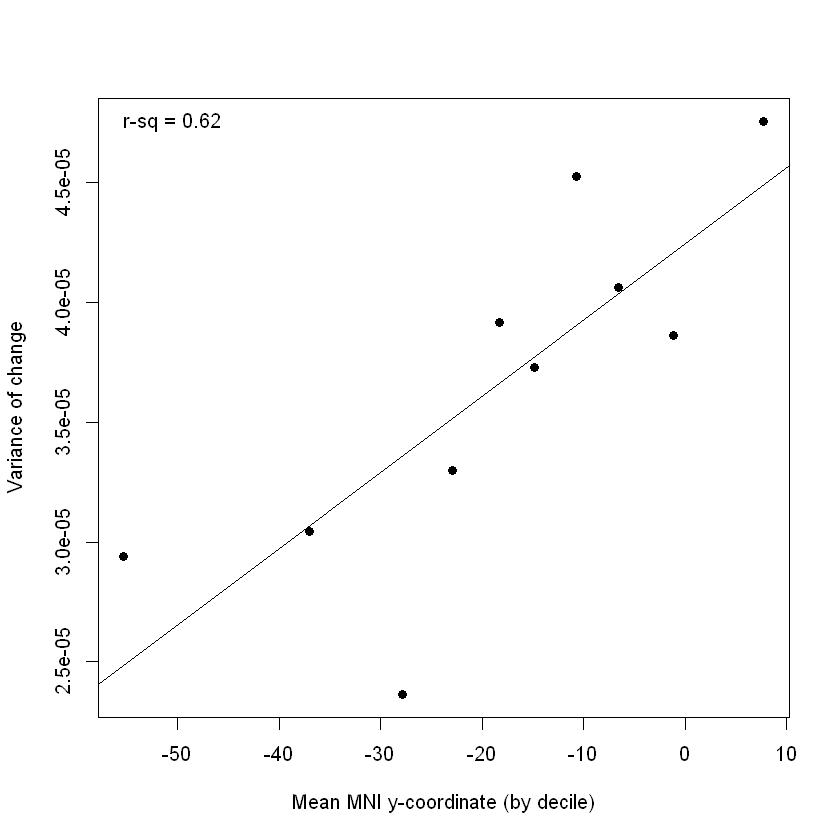

In [113]:
tmp <- plot.coef.var(d = mncoeff, coor = mni$Y, ntl = 10)

In [116]:
summary(lm(ChVar ~ Coor, data = tmp))


Call:
lm(formula = ChVar ~ Coor, data = tmp)

Residuals:
       Min         1Q     Median         3Q        Max 
-9.941e-06 -1.731e-06  1.490e-08  2.629e-06  6.208e-06 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 4.244e-05  2.256e-06  18.810 6.59e-08 ***
Coor        3.180e-07  8.846e-08   3.594  0.00704 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.855e-06 on 8 degrees of freedom
Multiple R-squared:  0.6175,	Adjusted R-squared:  0.5697 
F-statistic: 12.92 on 1 and 8 DF,  p-value: 0.007042


In [118]:
summary(lm(ChVar ~ Coor, data = tmp))$coefficients[2,1]

[1] 3.179487e-07

This plot groups electrodes by anterior/posterior decile, regardless of which participants they come from. To ensure that this relationship is reliable across participants, we regressed variance-of-change on MNI-Y separately for each participant, estimating the slope $\beta$ of this relationship. We then assessed whether the slope is reliably positive across participants using a t.test against zero.

In [119]:
sjslope <- rep(0, times = 8) #initialize vector to contain slopes
sjnos <- c(1:5,7,9:10) #Vector indicating the ID numbers for the 8 participants

for(i in c(1:8)){
    s <- mni$sj==sjnos[i] #Select electrodes from participant i
    #Compute var of coeff change and MNI Y for all electrodes:
    suppressWarnings(tmp <- plot.coef.var(d=mncoeff[s,],coor=mni$Y[s], ntl=sum(s), pflag = F))
    # NOTE: Warnings suppressed b/c we are using ntiles equal to the number of data points, ie, not binning
    
    #Slope of model predicting var of coeff change from MNI-Y
    sjslope[i] <- summary(lm(ChVar ~ Coor, data = tmp))$coefficients[2,1]
    }
sjslope


[1]  1.038825e-06  4.265590e-07  5.531056e-07  2.946661e-07  1.678824e-06
[6]  8.856591e-09 -3.511523e-07  1.273110e-06

Slopes are positive for all subjects but one. Are they reliably positive? We run a one-tailed t-test:

In [121]:
t.test(sjslope, alternative = "greater")



	One Sample t-test

data:  sjslope
t = 2.5793, df = 7, p-value = 0.01825
alternative hypothesis: true mean is greater than 0
95 percent confidence interval:
 1.633599e-07          Inf
sample estimates:
   mean of x 
6.153491e-07 


Slopes reliably greater than zero with $p < 0.02$.